In [100]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import MeanSquaredError

In [5]:
import importlib
importlib.reload(readcsv1)
### forsome reason it doesn't autoreload the python files

<module 'readcsv1' from 'C:\\Users\\lkkcp\\Desktop\\NeuralNetwork\\ECE247-project-main\\readcsv1.py'>

In [6]:
## strange error only on macOS apparently 
## https://github.com/dmlc/xgboost/issues/1715
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
## get data, just Close values
#importlib.reload(readcsv1)
import readcsv1
fulldata = readcsv1.get_data(start = '1997-01-17',verbose=True,normalize=True).astype(np.float32)
print(fulldata.shape)

0 Data/000-EuroPerDollar(USDEUR).csv Close
1 Data/000-EuroPerDollar(USDEUR).csv Open
2 Data/000-EuroPerDollar(USDEUR).csv High
3 Data/000-EuroPerDollar(USDEUR).csv Low
4 Data/Bond-Germany2-yearNoteYield(IGDEU2D).csv Close
5 Data/Bond-Germany9-yearNoteYield(IGDEU9D).csv Close
6 Data/Bond-MoodyBAA(MOCBAAD).csv Close
7 Data/Bond-US10-yearBondYield(IGUSA10D).csv Close
8 Data/Bond-US2-yearNoteYield(IGUSA2D).csv Close
9 Data/Commod-GoldPrice(__XAU_D).csv Close
10 Data/Commod-GoldPrice(__XAU_D).csv Open
11 Data/Commod-GoldPrice(__XAU_D).csv High
12 Data/Commod-GoldPrice(__XAU_D).csv Low
13 Data/Commod-OilPrice(__WTC_D).csv Close
14 Data/Commod-OilPrice(__WTC_D).csv Open
15 Data/Commod-OilPrice(__WTC_D).csv High
16 Data/Commod-OilPrice(__WTC_D).csv Low
17 Data/Commod-ReutersCRBIndex(_TRCCRBD).csv Close
18 Data/Commod-ReutersCRBIndex(_TRCCRBD).csv Open
19 Data/Commod-ReutersCRBIndex(_TRCCRBD).csv High
20 Data/Commod-ReutersCRBIndex(_TRCCRBD).csv Low
21 Data/Commod-ReutersCRBIndustrialRaw(CMCRBI

In [67]:
## indicators to use when training
biglist = [0,1,2,3,4,5,7,8,27,28,29,30,31,32,33,34,35,36,62,63,64,65,66,67,68,69,70,71,72,73,82,83,84,85,86]
smalllist =[0,1,2,3]
#data = fulldata[:,biglist]
data = fulldata[:,smalllist]
data.shape

(8750, 4)

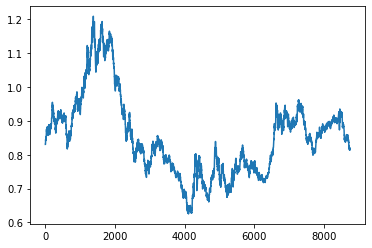

In [68]:
## visualize data
plt.plot(data[:, 0])
plt.show()

In [8]:
def generate_batches(data, label, batch_size, learn_window, predict_window, seed=None):
    """
    Randomly generate batches of windows, with replacement.
    
    - data: array, shape = (N, C)
    - label: the target to be predicted. Can be the closing price or slope of closing price etc.
    - batch_size: integer
    - learn_window: array of indices to learn from.
    - predict_window: array of indices to predict.
    - seed: seed for RNG, if any
    
    e.g. if learn_window = [0, 1, 2, ..., 9] and predict_window = [0, 1, 2, 3, 4],
    then learn on 10 days and try to predict next 5 days.
    
    returns: generator that yields random (X, y)
    - X_batch: shape = (B, len(learn_window), C)
    - y_batch: shape = (B, len(predict_window))
    """
    
    if seed != None:
        np.random.seed(seed)
        
    learn_window = np.array(learn_window)
    predict_window = np.array(predict_window)
    
    N, C = data.shape
    L, P = len(learn_window), len(predict_window)
    Lcap, Pcap = int(np.max(learn_window))+1, int(np.max(predict_window))+1
    
    X = np.zeros((batch_size, L, C))
    y = np.zeros((batch_size, P))
    
    i = 0 # tracks index
    k = 0 # tracks batch size
    M = N - Lcap - Pcap # ceiling for i
    while True:
        
        if k == batch_size:
            k = 0
            yield X, y
            
        i = np.random.randint(0, M)
        X[k] = data[i+learn_window,:]
        y[k] = label[i+Lcap+predict_window] 
        
        k += 1

        
## short test; should not throw error
G = generate_batches(data, data[:,0], 7, np.arange(50), np.arange(1))

X_batch, y_batch = next(G)
print(X_batch.shape)
print(y_batch.shape)

(7, 50, 4)
(7, 1)


# Now train to predict the closing prices of next X days using pure CNN

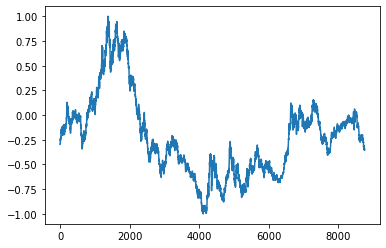

In [71]:
## ===== Preprocessing ==============================
## scale all data into interval [-1, 1]
data = fulldata[:,smalllist]

close_max = np.amax(data[:,0])
close_min = np.amin(data[:,0])
close_mid = (close_max + close_min)/2
scale = (close_max -close_min)/2

data = (data-close_mid)/scale
plt.plot(data[:,0])

In [72]:
## split into training, validation, and testing sets
data_train = data[:-1500, :]
data_val = data[-1500:-500, :]
data_test = data[-500:,:]
print("Training:", data_train.shape)
print("Testing:", data_test.shape)
print("Validation:", data_val.shape)

Training: (7250, 4)
Testing: (500, 4)
Validation: (1000, 4)


In [107]:
## ===== model hyperparameters ======================
learn_window = np.arange(40)    ## learn from past 40 days, which is two months. 
predict_window = np.arange(10)   ## predict next 5 days

batch_size = 50
initial_learning_rate = 1e-4   
decay_steps = 300
decay_rate = 0.9
L1reg = 0.001
L2reg = 0
drop_prob = 0.2

## ==================================================

_, C = data_train.shape
L, P = len(learn_window), len(predict_window)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate, 
    decay_steps=decay_steps, 
    decay_rate=decay_rate)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
#opt = keras.optimizers.Adam(learning_rate=initial_learning_rate)


model_1d = models.Sequential()
model_1d.add(layers.Conv1D(32, 3, input_shape=(L, C), activation = 'relu', kernel_regularizer = keras.regularizers.l2(L2reg)))
# 38 timesteps
model_1d.add(layers.Conv1D(32, 3, input_shape=(L, C), activation = 'relu', kernel_regularizer = keras.regularizers.l2(L2reg)))
# 36 timesteps
model_1d.add(layers.Conv1D(64, 3, input_shape=(L, C), activation = 'relu', kernel_regularizer = keras.regularizers.l2(L2reg)))
# 34 timesteps
model_1d.add(layers.Conv1D(64, 3, input_shape=(L, C), activation = 'relu', kernel_regularizer = keras.regularizers.l2(L2reg)))
# 32 timesteps
model_1d.add(layers.AveragePooling1D(pool_size=2,strides=2))
#16 timesteps
model_1d.add(layers.Conv1D(128, 3, input_shape=(L, C), activation = 'relu', kernel_regularizer = keras.regularizers.l2(L2reg)))
#14 timesteps
model_1d.add(layers.AveragePooling1D(pool_size=2,strides=2))
#7 timesteps
model_1d.add(layers.Reshape((7*128,)))
model_1d.add(layers.Dense(100,activation = 'relu', kernel_regularizer = keras.regularizers.l2(L2reg)))
model_1d.add(layers.Dense(P) )
model_1d.compile(optimizer=opt, loss='mse',metrics=[keras.metrics.MeanSquaredError()])
model_1d.summary()

## Add dropout?
## Add regularization? 

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_61 (Conv1D)           (None, 38, 32)            416       
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 36, 32)            3104      
_________________________________________________________________
conv1d_63 (Conv1D)           (None, 34, 64)            6208      
_________________________________________________________________
conv1d_64 (Conv1D)           (None, 32, 64)            12352     
_________________________________________________________________
average_pooling1d_30 (Averag (None, 16, 64)            0         
_________________________________________________________________
conv1d_65 (Conv1D)           (None, 14, 128)           24704     
_________________________________________________________________
average_pooling1d_31 (Averag (None, 7, 128)          

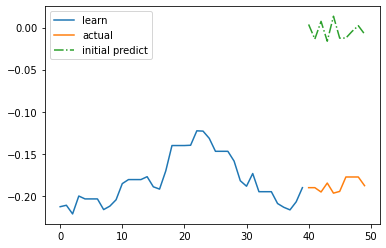

In [108]:
## generate validation data
G = generate_batches(data_val, data_val[:,0], 200, learn_window, predict_window)
X_val_batch, y_val_batch = next(G)

#### Before training, let's see what the model would predict for one sample in the val data
init_pred = model_1d.predict(X_val_batch[0:1,:,:])
Lcap = np.max(learn_window)+1
plt.plot(learn_window, X_val_batch[0, :, 0], label='learn')
plt.plot(Lcap+predict_window, y_val_batch[0], label='actual')
plt.plot(Lcap+predict_window, init_pred[0], '-.', label='initial predict')
plt.legend()
plt.show()

In [109]:
## train
G = generate_batches(data_train, data_train[:,0], batch_size, learn_window, predict_window)

model_1d.fit(G, steps_per_epoch=300, epochs=20, validation_data=(X_val_batch, y_val_batch))

Epoch 1/20
300/300 [==============================] - 10s 33ms/step - loss: 0.0320 - mean_squared_error: 0.0320 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 2/20
300/300 [==============================] - 7s 24ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 3/20
300/300 [==============================] - 8s 26ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 4/20
300/300 [==============================] - 8s 28ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 5/20
300/300 [==============================] - 9s 29ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 9.7326e-04 - val_mean_squared_error: 9.7326e-04
Epoch 6/20
300/300 [==============================] - 9s 30ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 9.4567e-04 - val_mean_squared_error: 9.4567e-04
Epoch

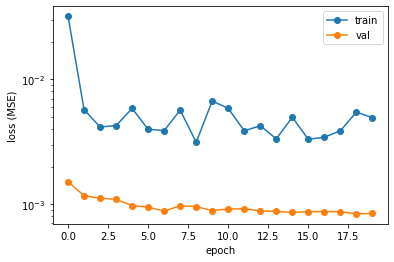

In [110]:
train_loss = model_1d.history.history['loss']
val_loss = model_1d.history.history['val_loss']

plt.plot(train_loss, '-o', label='train')
plt.plot(val_loss, '-o', label='val')
plt.ylabel('loss (MSE)')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend()
plt.show()

In [92]:
N, C = data_val.shape
L, P = len(learn_window), len(predict_window)
Lcap, Pcap = int(np.max(learn_window))+1, int(np.max(predict_window))+1
M = N - Lcap - Pcap # ceiling for i

In [111]:
## test on all testing data

detail_window = np.arange(Pcap)

X_learn = np.zeros((M, L, C))
y_detail = np.zeros((M, Pcap))
y_predict = np.zeros((M, P))

for i in range(M):
    X_learn[i] = data_val[i+learn_window]
    y_detail[i] = data_val[i+Lcap+detail_window, 0]

y_predict = model_1d.predict(X_learn)

stream = np.zeros(M)
for i in range(M):
    mse = np.mean(np.square(y_detail[i, predict_window] - y_predict[i]))
#    scale_factor = 1/(scale)   ## bring back to original scale

    mse *= (scale**2)
    
    stream[i] = mse
    
print("Average MSE: %.5e" % np.mean(stream))

Average MSE: 8.62990e-05


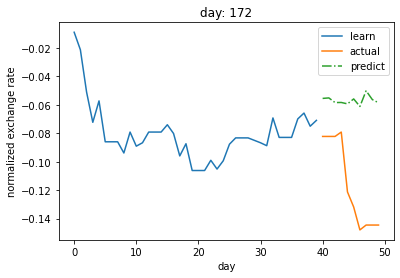

MSE: 3.728e-04


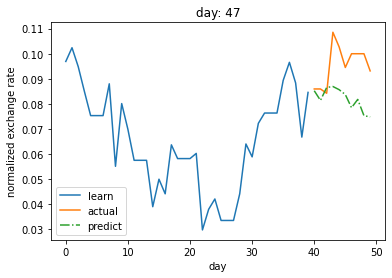

MSE: 2.251e-05


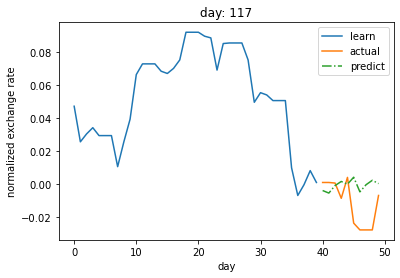

MSE: 2.734e-05


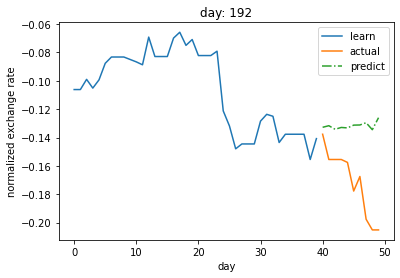

MSE: 1.834e-04


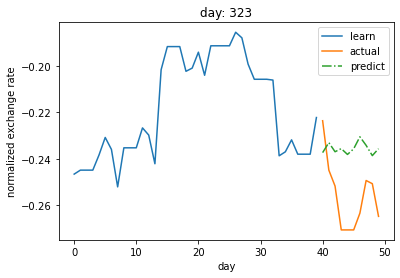

MSE: 5.395e-05


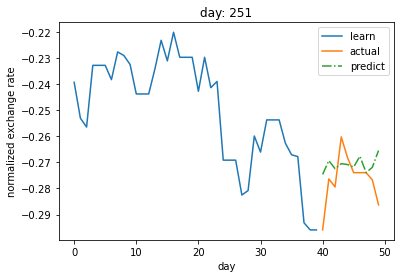

MSE: 9.904e-06


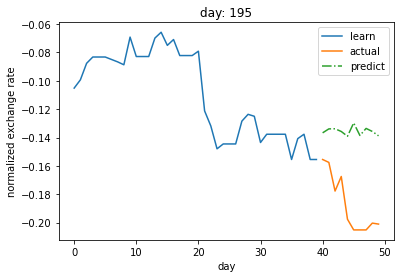

MSE: 2.607e-04


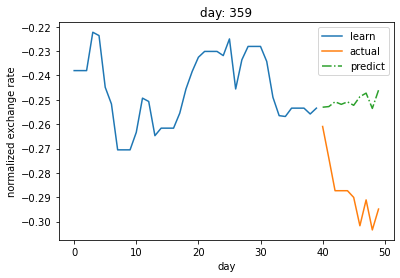

MSE: 1.319e-04


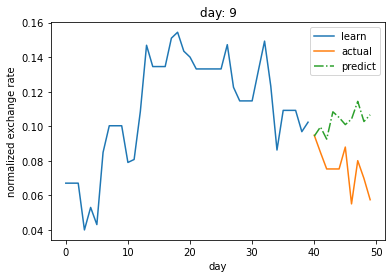

MSE: 8.310e-05


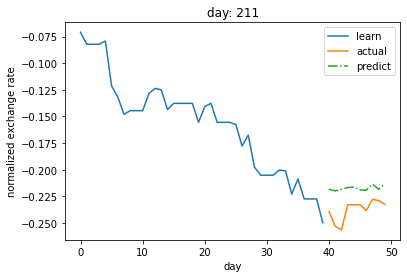

MSE: 4.075e-05


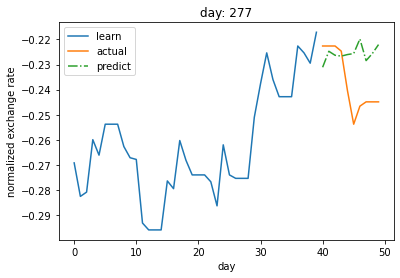

MSE: 2.534e-05


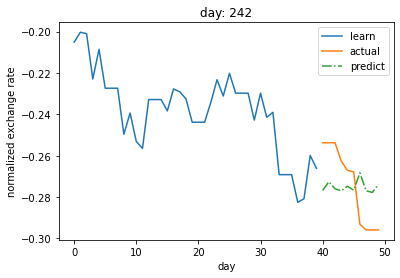

MSE: 2.993e-05


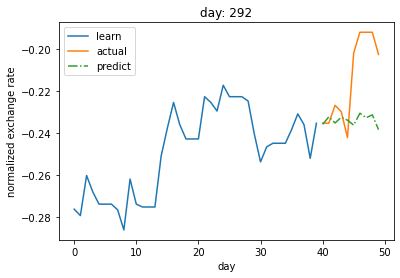

MSE: 6.284e-05


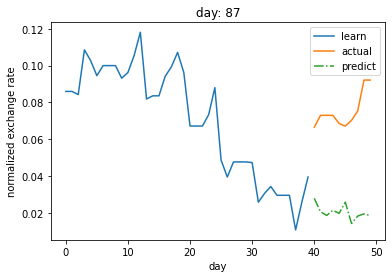

MSE: 2.653e-04


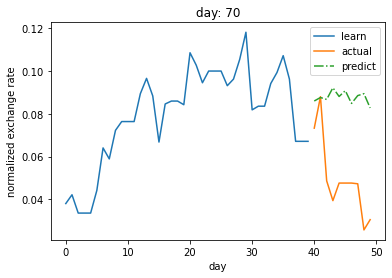

MSE: 1.517e-04


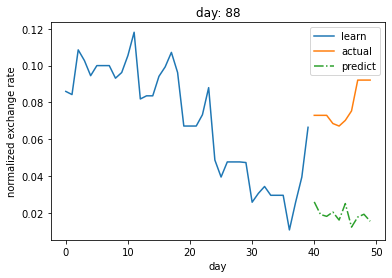

MSE: 3.061e-04


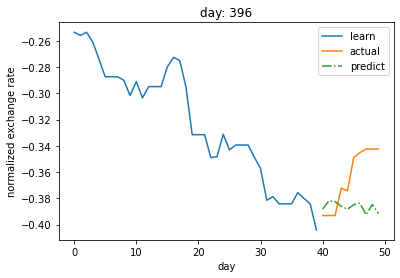

MSE: 8.649e-05


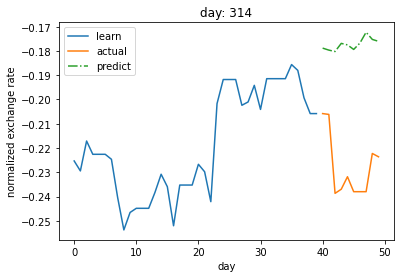

MSE: 2.336e-04


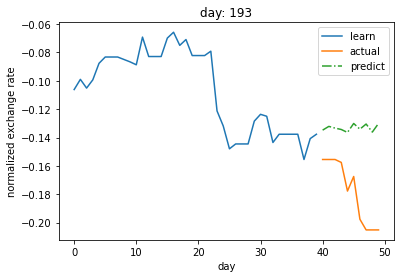

MSE: 2.141e-04


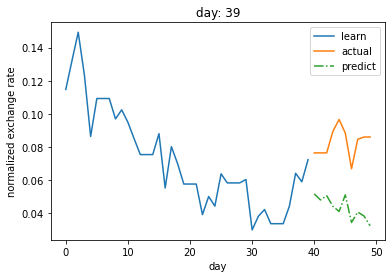

MSE: 1.430e-04


In [112]:
np.random.seed(0)
for i in np.random.randint(0, M, size=20):
    
    plt.plot(learn_window, X_learn[i, :, 0], label='learn')
    plt.plot(Lcap+detail_window, y_detail[i], label='actual')
    plt.plot(Lcap+predict_window, y_predict[i], '-.', label='predict')
    plt.title('day: %d' % i)
    plt.ylabel('normalized exchange rate')
    plt.xlabel('day')
    plt.legend()
    plt.show()

    mse = np.mean(np.square(y_detail[i, predict_window] - y_predict[i]))
#    scale_factor = 1/scale   ## bring back to original scale
    mse *= (scale**2)
    
    print("MSE: %.3e" % mse)

# Predict the slope (and intercept) of next X days

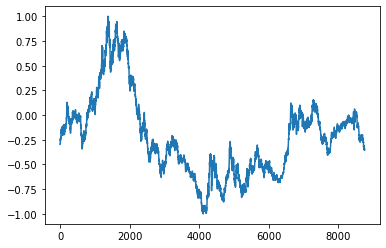

In [113]:
## ===== Preprocessing ==============================
## scale all data into interval [-1, 1]
data = fulldata[:,smalllist]

close_max = np.amax(data[:,0])
close_min = np.amin(data[:,0])
close_mid = (close_max + close_min)/2
scale = (close_max -close_min)/2

data = (data-close_mid)/scale
plt.plot(data[:,0])

In [266]:
## ===== model hyperparameters ======================
learn_window = np.arange(40)    ## learn from past 40 days, which is two months. 
predict_window = np.arange(15)   ## predict slope of next 15 days. #It must be continuous

batch_size = 50
initial_learning_rate = 1e-3   
decay_steps = 300
decay_rate = 0.9
L1reg = 0.001
L2reg = 0.001
drop_prob = 0.2
## ==================================================

Calculate the actual slopes of the days  the predict_window.

E.g. If predict_window = [0,2,5,8], then calculate the slope (and intercept) of days [0,1,2,...,8].

The linear regrssion formula is $\hat\beta = (X^T X)^{-1} X^T Y$

In [251]:
##calculate the slopes and intercepts
Pcap = np.amax(predict_window)+1
#pred_detailed_window = np.arange(Pcap)

target = np.zeros((data.shape[0]-Pcap+1, 2)) 
## target is shape (N,2), which contains the slope and intercepts. 
## The ith row contains the slope of day i, i+1,...,i+Pcap-1.

for i in range(target.shape[0]):
    tempx = np.vstack((predict_window, np.ones(Pcap)))
    tempy = data[i+predict_window,0]
    target[i,:] = np.linalg.inv(tempx.dot(tempx.T)).dot(tempx.dot(tempy))
    
target = np.vstack((target, np.zeros((Pcap-1,2))))  # The last Pcap-1 of the target are zeros, because not enough data

In [252]:
#### Split the data
#### Match the target variables so that ith y is the slope of (i+1)th day to (i+1+predict_N_days)th day

data_train = data[:-1600, :]
y_train = target[:-1600,:]
data_val = data[-1600:-600, :]
y_val = target[-1600:-600,:]
data_test = data[-600:,:]
y_test = target[-600:]
print("Training data:", data_train.shape)
print("Training target:", y_train.shape)
print("Validation data:", data_val.shape)
print("Validation target:", y_val.shape)
print("Testing data:", data_test.shape)
print("Testing target:", data_test.shape)

Training data: (7150, 4)
Training target: (7150, 2)
Validation data: (1000, 4)
Validation target: (1000, 2)
Testing data: (600, 4)
Testing target: (600, 4)


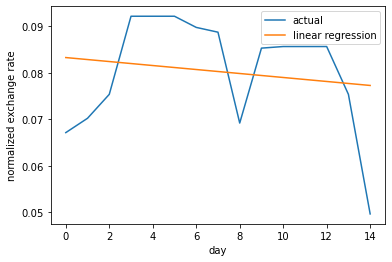

In [253]:
##Check that it worked by plotting
start_day = 232
plt.plot(predict_window, data_val[start_day+predict_window, 0], label='actual')
plt.plot(predict_window, y_val[start_day,0]*predict_window
         + y_val[start_day,1] , label='linear regression')
plt.ylabel('normalized exchange rate')
plt.xlabel('day')
plt.legend()
plt.show()

In [268]:
_, C = data_train.shape
L, Pcap = len(learn_window), len(predict_window)  # predict window has to be continuous. 
num_beta = y_test.shape[1]

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate, 
    decay_steps=decay_steps, 
    decay_rate=decay_rate)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
#opt = keras.optimizers.Adam(learning_rate=initial_learning_rate)


model_slope = models.Sequential()
model_slope.add(layers.Conv1D(32, 3, input_shape=(L, C), activation = 'relu', kernel_regularizer = keras.regularizers.l2(L2reg)))
# 38 timesteps
model_slope.add(layers.Conv1D(32, 3, input_shape=(L, C), activation = 'relu', kernel_regularizer = keras.regularizers.l2(L2reg)))
# 36 timesteps
model_slope.add(layers.Conv1D(64, 3, input_shape=(L, C), activation = 'relu', kernel_regularizer = keras.regularizers.l2(L2reg)))
# 34 timesteps
model_slope.add(layers.Conv1D(64, 3, input_shape=(L, C), activation = 'relu', kernel_regularizer = keras.regularizers.l2(L2reg)))
# 32 timesteps
model_slope.add(layers.AveragePooling1D(pool_size=2,strides=2))
#16 timesteps
model_slope.add(layers.Conv1D(128, 3, input_shape=(L, C), activation = 'relu', kernel_regularizer = keras.regularizers.l2(L2reg)))
#14 timesteps
model_slope.add(layers.AveragePooling1D(pool_size=2,strides=2))
#7 timesteps
model_slope.add(layers.Reshape((7*128,)))
model_slope.add(layers.Dense(100,activation = 'relu', kernel_regularizer = keras.regularizers.l2(L2reg)))
model_slope.add(layers.Dense(num_beta))  ### Predicting two values: slope and intercept

# The last layer then turns the slope and intercept to prediction of price.
# This layer is not trainable.
# First define the initializer that initializes weight to be {{1,1,1,...},{0,1,2,3,...},{0,1,4,9,...},...} (for linear regression)
def custom_init(shape,dtype=None):
    w = np.ones(shape)
    for i in range(1,shape[0]):
        w[i] = np.arange(shape[1])**i
    return w
        
model_slope.add(layers.Dense(Pcap,kernel_initializer=custom_init,use_bias=False))
model_slope.layers[-1].trainable = False


model_slope.compile(optimizer=opt, loss='mse', metrics=[keras.metrics.MeanSquaredError()])
model_slope.summary()

## Add dropout?
## Add regularization? 

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_111 (Conv1D)          (None, 38, 32)            416       
_________________________________________________________________
conv1d_112 (Conv1D)          (None, 36, 32)            3104      
_________________________________________________________________
conv1d_113 (Conv1D)          (None, 34, 64)            6208      
_________________________________________________________________
conv1d_114 (Conv1D)          (None, 32, 64)            12352     
_________________________________________________________________
average_pooling1d_50 (Averag (None, 16, 64)            0         
_________________________________________________________________
conv1d_115 (Conv1D)          (None, 14, 128)           24704     
_________________________________________________________________
average_pooling1d_51 (Averag (None, 7, 128)          

In [255]:
def generate_batches2(data, target, batch_size, learn_window, predict_window, seed=None):
    """
    Randomly generate batches of windows, with replacement.
    
    - data: array, shape = (N, C)
    - target: the target to be predicted. 
    - batch_size: integer
    - learn_window: array of indices to learn from.
    - predict_window: The window to predict. Must be continuous
    - seed: seed for RNG, if any
    
    e.g. if learn_window = [0, 1, 2, ..., 9] and predict_N_days is 15
    then learn on 10 days and predict the slope of the next 15 days, which is stored in target[24]
    
    returns: generator that yields random (X, y)
    - X_batch: shape = (B, len(learn_window), C)
    - y_batch: shape = (B, P), where P is the number of parameters to predict. 2 if it is just slope and intercept
    """
    
    if seed != None:
        np.random.seed(seed)
        
    learn_window = np.array(learn_window)
    predict_window=np.array(predict_window)
    
    N, C = data.shape
    L = len(learn_window)
    _, num_beta = target.shape  #number of parameters to predict
    Lcap = int(np.max(learn_window))+1
    Pcap = int(np.max(predict_window))+1
    
    X = np.zeros((batch_size, L, C))
    y = np.zeros((batch_size, Pcap))
    
    i = 0 # tracks index
    k = 0 # tracks batch size
    M = N - Lcap - Pcap # ceiling for i
    while True:
        
        if k == batch_size:
            k = 0
            yield X, y
            
        i = np.random.randint(0, M)
        X[k] = data[i+learn_window]
        y[k,:] = target[i+Lcap,0]*predict_window + target[i+Lcap,1]
        # The y values are not the actual prices, but the values on the linear regression of prices of the predict_window
        
        k += 1

        
## short test; should not throw error
G2 = generate_batches2(data_train, y_train, 7, np.arange(50), np.arange(15))

X_batch, y_batch = next(G2)
print(X_batch.shape)
print(y_batch.shape)

(7, 50, 4)
(7, 15)


In [269]:
## generate validation data
G2 = generate_batches2(data_val, y_val, 200, learn_window, predict_window)
X_val_batch, y_val_batch = next(G2)

In [270]:
## train
G2 = generate_batches2(data_train, y_train, batch_size, learn_window, predict_window)

model_slope.fit(G2, steps_per_epoch=300, epochs=40, validation_data=(X_val_batch, y_val_batch))

Epoch 1/40
300/300 [==============================] - 21s 70ms/step - loss: 0.1874 - mean_squared_error: 0.0266 - val_loss: 0.1014 - val_mean_squared_error: 0.0018
Epoch 2/40
300/300 [==============================] - 13s 43ms/step - loss: 0.0934 - mean_squared_error: 0.0157 - val_loss: 0.0620 - val_mean_squared_error: 0.0019
Epoch 3/40
300/300 [==============================] - 11s 38ms/step - loss: 0.0666 - mean_squared_error: 0.0174 - val_loss: 0.0448 - val_mean_squared_error: 0.0049
Epoch 4/40
300/300 [==============================] - 11s 38ms/step - loss: 0.0490 - mean_squared_error: 0.0153 - val_loss: 0.0301 - val_mean_squared_error: 0.0018
Epoch 5/40
300/300 [==============================] - 12s 39ms/step - loss: 0.0337 - mean_squared_error: 0.0093 - val_loss: 0.0242 - val_mean_squared_error: 0.0033
Epoch 6/40
300/300 [==============================] - 13s 43ms/step - loss: 0.0324 - mean_squared_error: 0.0139 - val_loss: 0.0181 - val_mean_squared_error: 0.0018
Epoch 7/40
300/3

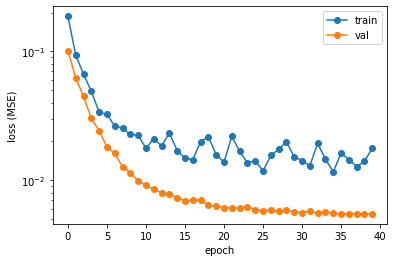

In [271]:
train_loss = model_slope.history.history['loss']
val_loss = model_slope.history.history['val_loss']

plt.plot(train_loss, '-o', label='train')
plt.plot(val_loss, '-o', label='val')
plt.ylabel('loss (MSE)')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend()
plt.show()

In [272]:
N, C = data_val.shape
L, num_beta = len(learn_window), y_val.shape[1]
Lcap, Pcap = int(np.max(learn_window))+1, np.amax(predict_window)+1
M = N - Lcap - Pcap + 1 # ceiling for i

In [273]:
## test on all validation data

#detail_window = np.arange(Pcap)

X_learn = np.zeros((M, L, C))
y_actual = np.zeros((M, Pcap))
y_actual_linear = np.zeros((M, Pcap))
y_predict = np.zeros((M, Pcap))

for i in range(M):
    X_learn[i] = data_val[i+learn_window]
    y_actual[i] = data_val[i+Lcap+predict_window, 0]
    y_actual_linear[i] = y_val[i+Lcap,0]*predict_window + y_val[i+Lcap,1]

y_predict = model_slope.predict(X_learn)

#The MSE is using the error between the linear prediction and the actual values.
mse = np.mean((y_actual - y_predict)**2)
## bring back to original scale
mse *= (scale**2)
    
#    stream[i] = mse
    
print("Average MSE: %.5e" % np.mean(stream))

Average MSE: 8.62990e-05


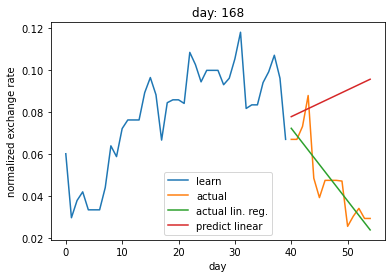

MSE: 1.709e-04


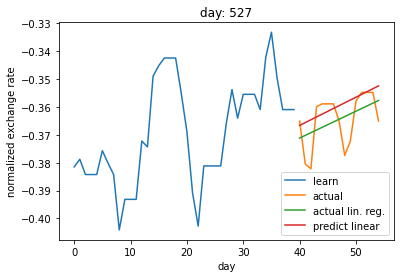

MSE: 7.593e-06


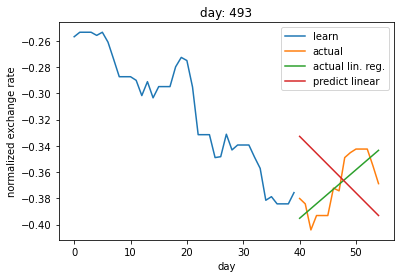

MSE: 1.216e-04


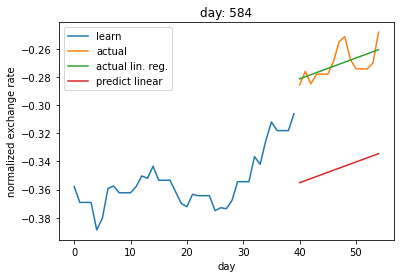

MSE: 4.713e-04


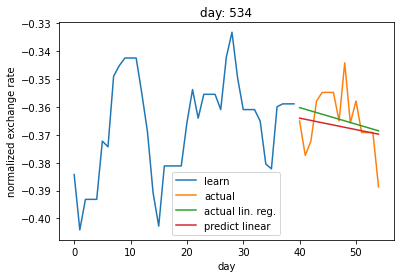

MSE: 9.477e-06


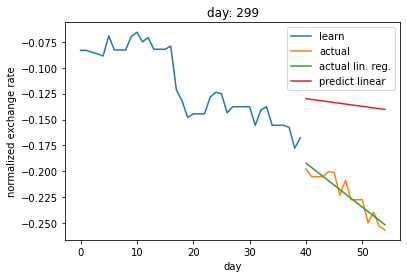

MSE: 6.654e-04


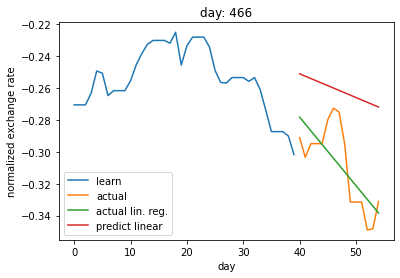

MSE: 2.249e-04


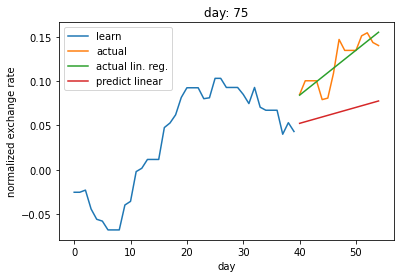

MSE: 2.887e-04


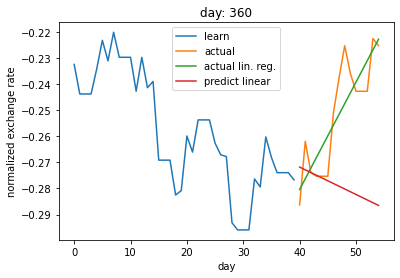

MSE: 1.164e-04


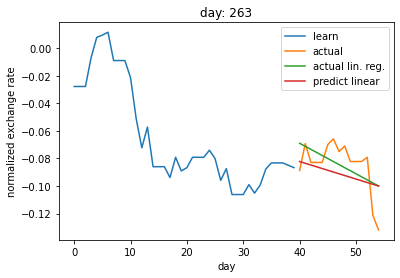

MSE: 2.431e-05


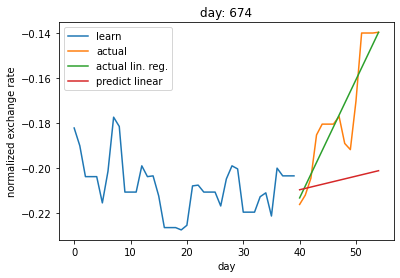

MSE: 1.156e-04


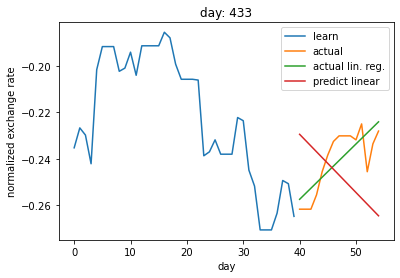

MSE: 4.652e-05


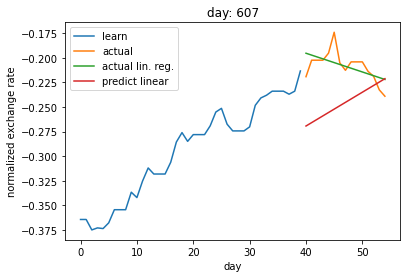

MSE: 1.729e-04


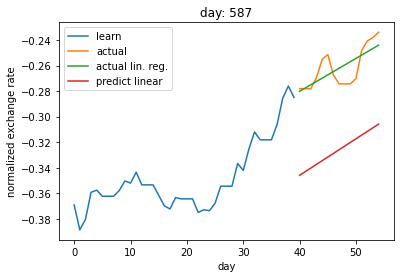

MSE: 3.568e-04


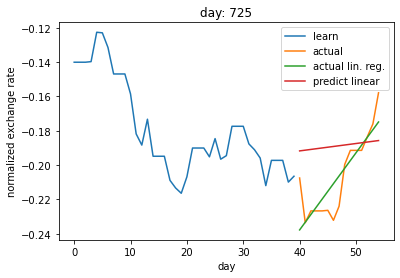

MSE: 6.529e-05


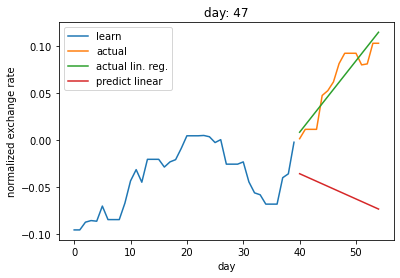

MSE: 1.329e-03


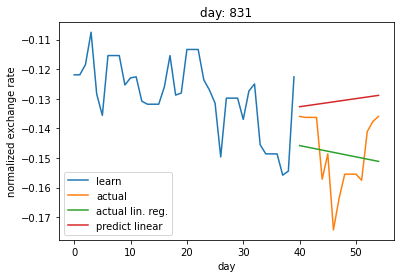

MSE: 3.934e-05


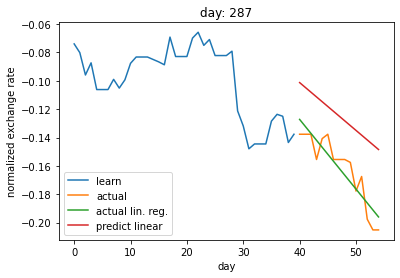

MSE: 1.276e-04


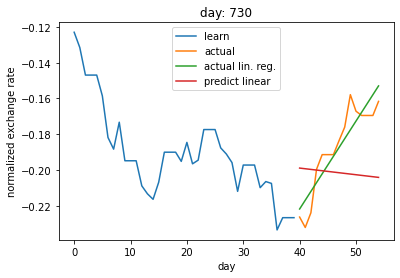

MSE: 6.920e-05


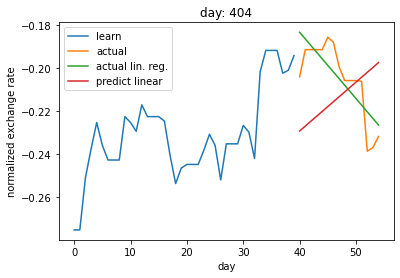

MSE: 6.121e-05


In [276]:
np.random.seed(2)
for i in np.random.randint(0, M, size=20):
    
    plt.plot(learn_window, X_learn[i, :, 0], label='learn')
    plt.plot(Lcap+predict_window, y_actual[i], label='actual')
    plt.plot(Lcap+predict_window, y_actual_linear[i], label='actual lin. reg.')
    plt.plot(Lcap+predict_window, y_predict[i], label='predict linear')
    
    ### Double check that the y_actual_linear has no bug
    ### Compute the linear regression again and plot it to see that they overlap
#    tempx = np.vstack((predict_window, np.ones(Pcap)))
#    tempy = y_actual[i]
#    beta_correct = np.linalg.inv(tempx.dot(tempx.T)).dot(tempx.dot(tempy))
#    y_linear_correct = beta_correct.dot(tempx)
#    plt.plot(Lcap+predict_window, y_linear_correct, label='the correct lin.reg')
    ### Now I've checked there is not bug. 
    
    plt.title('day: %d' % i)
    plt.ylabel('normalized exchange rate')
    plt.xlabel('day')
    plt.legend()
    plt.show()

    mse = np.mean(np.square(y_actual[i] - y_predict[i]))
    mse *= (scale**2)
    
    print("MSE: %.3e" % mse)